In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import torch
from torch.utils.data import Dataset
from datasets import BaseDataset

# Is options the instance of a class? In the end mixed_dataset only passes it to base_dataset, which uses
# noise factor, scale factor and rotation factor

class Options:
    pass

options = Options()

options.noise_factor = 1
options.scale_factor = 1
options.rot_factor = 1

train_ds = BaseDataset(options, '3dpw', is_train=False) # is_train has to be false since 3dpw is only used for evaluation

In [4]:
train_ds[0] # Now 3dpw is in ../Datasets/3dpw

{'img': tensor([[[-2.1179, -2.1179, -1.7754,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -1.7754,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -1.7754,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -1.7754,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -1.7754,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -1.8268,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -1.7556,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -1.7556,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -1.7556,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -1.7031,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -1.7031,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -1.7556,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.6302,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -

In [5]:
train_ds[0]['img'].shape

torch.Size([3, 224, 224])

In [ ]:
train_ds = BaseDataset(options, 'mpii', is_train=False) # Loading mpii to check if it has_smpl

In [ ]:
train_ds = BaseDataset(options, 'mpi-inf-3dhp') # Loading mpii to check is has_smpl = True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


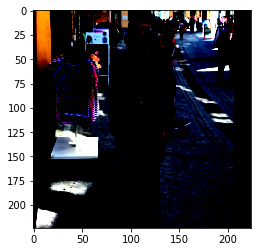

In [37]:
%matplotlib inline

import matplotlib.pyplot as plt

img_t = train_ds[0]['img']

plt.imshow(img_t.permute(1, 2, 0))
plt.show()

In [36]:
train_ds[3200]['betas'] - train_ds[0]['betas'] # Betas are the same for the length of the clip, and for each clip with the same subject!!

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [18]:
import torch
import torch.nn as nn
import torchvision.models.resnet as resnet
import numpy as np
import math
from utils.geometry import rot6d_to_rotmat

class Bottleneck(nn.Module):
    """ Redefinition of Bottleneck residual block
        Adapted from the official PyTorch implementation
    """
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class HMR(nn.Module):
    """ SMPL Iterative Regressor with ResNet50 backbone
    """

    def __init__(self, block, layers, smpl_mean_params):
        self.inplanes = 64
        super(HMR, self).__init__()
        npose = 24 * 6
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc1 = nn.Linear(512 * block.expansion + npose + 13, 1024) # -10 to remove betas from fully connected layer
        self.drop1 = nn.Dropout()
        self.fc2 = nn.Linear(1024, 1024)
        self.drop2 = nn.Dropout()
        self.decpose = nn.Linear(1024, npose)
        # self.decshape = nn.Linear(1024, 10)
        self.deccam = nn.Linear(1024, 3)
        nn.init.xavier_uniform_(self.decpose.weight, gain=0.01)
        # nn.init.xavier_uniform_(self.decshape.weight, gain=0.01)
        nn.init.xavier_uniform_(self.deccam.weight, gain=0.01)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

        mean_params = np.load(smpl_mean_params)
        init_pose = torch.from_numpy(mean_params['pose'][:]).unsqueeze(0)
        # init_shape = torch.from_numpy(mean_params['shape'][:].astype('float32')).unsqueeze(0)
        init_cam = torch.from_numpy(mean_params['cam']).unsqueeze(0)
        self.register_buffer('init_pose', init_pose)
        # self.register_buffer('init_shape', init_shape)
        self.register_buffer('init_cam', init_cam)


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x, betas, init_pose=None, init_cam=None, n_iter=3): # Removed init_shape=None, inserted betas

        batch_size = x.shape[0]

        if init_pose is None:
            init_pose = self.init_pose.expand(batch_size, -1)
        #if init_shape is None:
        #    init_shape = self.init_shape.expand(batch_size, -1)
        if init_cam is None:
            init_cam = self.init_cam.expand(batch_size, -1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        xf = self.avgpool(x4)
        xf = xf.view(xf.size(0), -1)

        pred_pose = init_pose
        #pred_shape = init_shape
        gt_shape = betas
        pred_cam = init_cam
        for i in range(n_iter):
            xc = torch.cat([xf, pred_pose, gt_shape, pred_cam],1) # replaced pred_shape with gt_shape
            xc = self.fc1(xc)
            xc = self.drop1(xc)
            xc = self.fc2(xc)
            xc = self.drop2(xc)
            pred_pose = self.decpose(xc) + pred_pose
            # pred_shape = self.decshape(xc) + pred_shape
            pred_cam = self.deccam(xc) + pred_cam
            
        
        pred_rotmat = rot6d_to_rotmat(pred_pose).view(batch_size, 24, 3, 3)

        return pred_rotmat, pred_cam # removed pred_shape

def hmr(smpl_mean_params, pretrained=True, **kwargs):
    """ Constructs an HMR model with ResNet50 backbone.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = HMR(Bottleneck, [3, 4, 6, 3],  smpl_mean_params, **kwargs)
    if pretrained:
        resnet_imagenet = resnet.resnet50(pretrained=True)
        model.load_state_dict(resnet_imagenet.state_dict(),strict=False)
    return model


In [16]:
import config

model = hmr(config.SMPL_MEAN_PARAMS, pretrained=True)

In [17]:
x = train_ds[0]['img'].unsqueeze(0)
betas = train_ds[0]['betas'].unsqueeze(0)

model(x,betas)

(tensor([[[[ 9.9628e-01, -5.3080e-02, -6.7912e-02],
           [-5.3904e-02, -9.9849e-01, -1.0364e-02],
           [-6.7260e-02,  1.3986e-02, -9.9764e-01]],
 
          [[ 9.9770e-01, -5.7080e-03, -6.7536e-02],
           [ 2.1359e-02,  9.7215e-01,  2.3337e-01],
           [ 6.4323e-02, -2.3428e-01,  9.7004e-01]],
 
          [[ 9.9814e-01,  1.7148e-02, -5.8520e-02],
           [-6.5470e-04,  9.6261e-01,  2.7090e-01],
           [ 6.0977e-02, -2.7035e-01,  9.6083e-01]],
 
          [[ 9.9207e-01, -4.9016e-02,  1.1577e-01],
           [ 8.1577e-02,  9.5166e-01, -2.9613e-01],
           [-9.5659e-02,  3.0322e-01,  9.4811e-01]],
 
          [[ 9.9398e-01,  1.0951e-01, -2.3370e-03],
           [-1.0341e-01,  9.3115e-01, -3.4966e-01],
           [-3.6114e-02,  3.4780e-01,  9.3687e-01]],
 
          [[ 9.9900e-01, -4.0206e-02,  1.9307e-02],
           [ 4.4534e-02,  8.7542e-01, -4.8131e-01],
           [ 2.4497e-03,  4.8169e-01,  8.7634e-01]],
 
          [[ 9.9626e-01,  6.8615e-02, -5.2499e

In [22]:
import torch
import torch.nn as nn
import numpy as np
from torchgeometry import angle_axis_to_rotation_matrix, rotation_matrix_to_angle_axis
import cv2

from datasets import MixedDataset
from models import hmr, SMPL
from smplify import SMPLify
from utils.geometry import batch_rodrigues, perspective_projection, estimate_translation
from utils.renderer import Renderer
from utils import BaseTrainer

import config
import constants
from .fits_dict import FitsDict


class Trainer(BaseTrainer):
    
    def init_fn(self):
        self.train_ds = MixedDataset(self.options, ignore_3d=self.options.ignore_3d, is_train=True)

        self.model = hmr(config.SMPL_MEAN_PARAMS, pretrained=True).to(self.device)
        self.optimizer = torch.optim.Adam(params=self.model.parameters(),
                                          lr=self.options.lr,
                                          weight_decay=0)
        self.smpl = SMPL(config.SMPL_MODEL_DIR,
                         batch_size=self.options.batch_size,
                         create_transl=False).to(self.device)
        # Per-vertex loss on the shape
        self.criterion_shape = nn.L1Loss().to(self.device)
        # Keypoint (2D and 3D) loss
        # No reduction because confidence weighting needs to be applied
        self.criterion_keypoints = nn.MSELoss(reduction='none').to(self.device)
        # Loss for SMPL parameter regression
        self.criterion_regr = nn.MSELoss().to(self.device)
        self.models_dict = {'model': self.model}
        self.optimizers_dict = {'optimizer': self.optimizer}
        self.focal_length = constants.FOCAL_LENGTH

        # Initialize SMPLify fitting module
        self.smplify = SMPLify(step_size=1e-2, batch_size=self.options.batch_size, num_iters=self.options.num_smplify_iters, focal_length=self.focal_length)
        if self.options.pretrained_checkpoint is not None:
            self.load_pretrained(checkpoint_file=self.options.pretrained_checkpoint)

        # Load dictionary of fits
        self.fits_dict = FitsDict(self.options, self.train_ds)

        # Create renderer
        self.renderer = Renderer(focal_length=self.focal_length, img_res=self.options.img_res, faces=self.smpl.faces)

    def finalize(self):
        self.fits_dict.save()

    def keypoint_loss(self, pred_keypoints_2d, gt_keypoints_2d, openpose_weight, gt_weight):
        """ Compute 2D reprojection loss on the keypoints.
        The loss is weighted by the confidence.
        The available keypoints are different for each dataset.
        """
        conf = gt_keypoints_2d[:, :, -1].unsqueeze(-1).clone()
        conf[:, :25] *= openpose_weight
        conf[:, 25:] *= gt_weight
        loss = (conf * self.criterion_keypoints(pred_keypoints_2d, gt_keypoints_2d[:, :, :-1])).mean()
        return loss

    def keypoint_3d_loss(self, pred_keypoints_3d, gt_keypoints_3d, has_pose_3d):
        """Compute 3D keypoint loss for the examples that 3D keypoint annotations are available.
        The loss is weighted by the confidence.
        """
        pred_keypoints_3d = pred_keypoints_3d[:, 25:, :]
        conf = gt_keypoints_3d[:, :, -1].unsqueeze(-1).clone()
        gt_keypoints_3d = gt_keypoints_3d[:, :, :-1].clone()
        gt_keypoints_3d = gt_keypoints_3d[has_pose_3d == 1]
        conf = conf[has_pose_3d == 1]
        pred_keypoints_3d = pred_keypoints_3d[has_pose_3d == 1]
        if len(gt_keypoints_3d) > 0:
            gt_pelvis = (gt_keypoints_3d[:, 2,:] + gt_keypoints_3d[:, 3,:]) / 2
            gt_keypoints_3d = gt_keypoints_3d - gt_pelvis[:, None, :]
            pred_pelvis = (pred_keypoints_3d[:, 2,:] + pred_keypoints_3d[:, 3,:]) / 2
            pred_keypoints_3d = pred_keypoints_3d - pred_pelvis[:, None, :]
            return (conf * self.criterion_keypoints(pred_keypoints_3d, gt_keypoints_3d)).mean()
        else:
            return torch.FloatTensor(1).fill_(0.).to(self.device)

    def shape_loss(self, pred_vertices, gt_vertices, has_smpl):
        """Compute per-vertex loss on the shape for the examples that SMPL annotations are available."""
        pred_vertices_with_shape = pred_vertices[has_smpl == 1]
        gt_vertices_with_shape = gt_vertices[has_smpl == 1]
        if len(gt_vertices_with_shape) > 0:
            return self.criterion_shape(pred_vertices_with_shape, gt_vertices_with_shape)
        else:
            return torch.FloatTensor(1).fill_(0.).to(self.device)

    def smpl_losses(self, pred_rotmat, gt_pose, has_smpl): # Remove pred_betas and gt_betas
        pred_rotmat_valid = pred_rotmat[has_smpl == 1]
        gt_rotmat_valid = batch_rodrigues(gt_pose.view(-1,3)).view(-1, 24, 3, 3)[has_smpl == 1]
        # pred_betas_valid = pred_betas[has_smpl == 1]
        #gt_betas_valid = gt_betas[has_smpl == 1]
        if len(pred_rotmat_valid) > 0:
            loss_regr_pose = self.criterion_regr(pred_rotmat_valid, gt_rotmat_valid)
            #loss_regr_betas = self.criterion_regr(pred_betas_valid, gt_betas_valid)
        else:
            loss_regr_pose = torch.FloatTensor(1).fill_(0.).to(self.device)
            #loss_regr_betas = torch.FloatTensor(1).fill_(0.).to(self.device)
        return loss_regr_pose # remove loss_regr_betas

    def train_step(self, input_batch):
        self.model.train()

        # Get data from the batch
        images = input_batch['img'] # input image
        gt_keypoints_2d = input_batch['keypoints'] # 2D keypoints
        gt_pose = input_batch['pose'] # SMPL pose parameters
        gt_betas = input_batch['betas'] # SMPL beta parameters
        gt_joints = input_batch['pose_3d'] # 3D pose
        has_smpl = input_batch['has_smpl'].byte() # flag that indicates whether SMPL parameters are valid
        has_pose_3d = input_batch['has_pose_3d'].byte() # flag that indicates whether 3D pose is valid
        is_flipped = input_batch['is_flipped'] # flag that indicates whether image was flipped during data augmentation
        rot_angle = input_batch['rot_angle'] # rotation angle used for data augmentation
        dataset_name = input_batch['dataset_name'] # name of the dataset the image comes from
        indices = input_batch['sample_index'] # index of example inside its dataset
        batch_size = images.shape[0]

        # Get GT vertices and model joints
        # Note that gt_model_joints is different from gt_joints as it comes from SMPL
        gt_out = self.smpl(betas=gt_betas, body_pose=gt_pose[:,3:], global_orient=gt_pose[:,:3])
        gt_model_joints = gt_out.joints
        gt_vertices = gt_out.vertices

        # Get current best fits from the dictionary
        opt_pose, opt_betas = self.fits_dict[(dataset_name, indices.cpu(), rot_angle.cpu(), is_flipped.cpu())]
        opt_pose = opt_pose.to(self.device)
        opt_betas = opt_betas.to(self.device)
        opt_output = self.smpl(betas=gt_betas, body_pose=opt_pose[:,3:], global_orient=opt_pose[:,:3]) # Bypass the need for opt_betas by replacing it with gt_betas here
        opt_vertices = opt_output.vertices
        opt_joints = opt_output.joints


        # De-normalize 2D keypoints from [-1,1] to pixel space
        gt_keypoints_2d_orig = gt_keypoints_2d.clone()
        gt_keypoints_2d_orig[:, :, :-1] = 0.5 * self.options.img_res * (gt_keypoints_2d_orig[:, :, :-1] + 1)

        # Estimate camera translation given the model joints and 2D keypoints
        # by minimizing a weighted least squares loss
        gt_cam_t = estimate_translation(gt_model_joints, gt_keypoints_2d_orig, focal_length=self.focal_length, img_size=self.options.img_res)

        opt_cam_t = estimate_translation(opt_joints, gt_keypoints_2d_orig, focal_length=self.focal_length, img_size=self.options.img_res)


        opt_joint_loss = self.smplify.get_fitting_loss(opt_pose, gt_betas, opt_cam_t, # replace opt_betas with gt_betas
                                                       0.5 * self.options.img_res * torch.ones(batch_size, 2, device=self.device),
                                                       gt_keypoints_2d_orig).mean(dim=-1)

        # Feed images in the network to predict camera and SMPL parameters
        pred_rotmat, pred_camera = self.model(images, gt_betas) # Remove pred_betas, Feed betas into the network

        pred_output = self.smpl(betas=gt_betas, body_pose=pred_rotmat[:,1:], global_orient=pred_rotmat[:,0].unsqueeze(1), pose2rot=False) # Replace pred_betas with gt_betas
        pred_vertices = pred_output.vertices
        pred_joints = pred_output.joints

        # Convert Weak Perspective Camera [s, tx, ty] to camera translation [tx, ty, tz] in 3D given the bounding box size
        # This camera translation can be used in a full perspective projection
        pred_cam_t = torch.stack([pred_camera[:,1],
                                  pred_camera[:,2],
                                  2*self.focal_length/(self.options.img_res * pred_camera[:,0] +1e-9)],dim=-1)


        camera_center = torch.zeros(batch_size, 2, device=self.device)
        pred_keypoints_2d = perspective_projection(pred_joints,
                                                   rotation=torch.eye(3, device=self.device).unsqueeze(0).expand(batch_size, -1, -1),
                                                   translation=pred_cam_t,
                                                   focal_length=self.focal_length,
                                                   camera_center=camera_center)
        # Normalize keypoints to [-1,1]
        pred_keypoints_2d = pred_keypoints_2d / (self.options.img_res / 2.)

        if self.options.run_smplify:

            # Convert predicted rotation matrices to axis-angle
            pred_rotmat_hom = torch.cat([pred_rotmat.detach().view(-1, 3, 3).detach(), torch.tensor([0,0,1], dtype=torch.float32,
                device=self.device).view(1, 3, 1).expand(batch_size * 24, -1, -1)], dim=-1)
            pred_pose = rotation_matrix_to_angle_axis(pred_rotmat_hom).contiguous().view(batch_size, -1)
            # tgm.rotation_matrix_to_angle_axis returns NaN for 0 rotation, so manually hack it
            pred_pose[torch.isnan(pred_pose)] = 0.0

            # Run SMPLify optimization starting from the network prediction
            new_opt_vertices, new_opt_joints,\
            new_opt_pose, new_opt_betas,\
            new_opt_cam_t, new_opt_joint_loss = self.smplify(
                                        pred_pose.detach(), gt_betas.detach(), # Replace pred_betas.detach() with gt_betas
                                        pred_cam_t.detach(),
                                        0.5 * self.options.img_res * torch.ones(batch_size, 2, device=self.device),
                                        gt_keypoints_2d_orig)
            new_opt_joint_loss = new_opt_joint_loss.mean(dim=-1)

            # Will update the dictionary for the examples where the new loss is less than the current one
            update = (new_opt_joint_loss < opt_joint_loss)
            

            opt_joint_loss[update] = new_opt_joint_loss[update]
            opt_vertices[update, :] = new_opt_vertices[update, :]
            opt_joints[update, :] = new_opt_joints[update, :]
            opt_pose[update, :] = new_opt_pose[update, :]
            opt_betas[update, :] = new_opt_betas[update, :]
            opt_cam_t[update, :] = new_opt_cam_t[update, :]


            self.fits_dict[(dataset_name, indices.cpu(), rot_angle.cpu(), is_flipped.cpu(), update.cpu())] = (opt_pose.cpu(), opt_betas.cpu())

        else:
            update = torch.zeros(batch_size, device=self.device).byte()

        # Replace extreme betas with zero betas
        opt_betas[(opt_betas.abs() > 3).any(dim=-1)] = 0.

        # Replace the optimized parameters with the ground truth parameters, if available
        opt_vertices[has_smpl, :, :] = gt_vertices[has_smpl, :, :]
        opt_cam_t[has_smpl, :] = gt_cam_t[has_smpl, :]
        opt_joints[has_smpl, :, :] = gt_model_joints[has_smpl, :, :]
        opt_pose[has_smpl, :] = gt_pose[has_smpl, :]
        opt_betas[has_smpl, :] = gt_betas[has_smpl, :]

        # Assert whether a fit is valid by comparing the joint loss with the threshold
        valid_fit = (opt_joint_loss < self.options.smplify_threshold).to(self.device)
        # Add the examples with GT parameters to the list of valid fits
        valid_fit = valid_fit | has_smpl

        opt_keypoints_2d = perspective_projection(opt_joints,
                                                  rotation=torch.eye(3, device=self.device).unsqueeze(0).expand(batch_size, -1, -1),
                                                  translation=opt_cam_t,
                                                  focal_length=self.focal_length,
                                                  camera_center=camera_center)


        opt_keypoints_2d = opt_keypoints_2d / (self.options.img_res / 2.)


        # Compute loss on SMPL parameters
        loss_regr_pose = self.smpl_losses(pred_rotmat, opt_pose, valid_fit) # Remove loss_regr_betas, pred_betas and opt_betas

        # Compute 2D reprojection loss for the keypoints
        loss_keypoints = self.keypoint_loss(pred_keypoints_2d, gt_keypoints_2d,
                                            self.options.openpose_train_weight,
                                            self.options.gt_train_weight)

        # Compute 3D keypoint loss
        loss_keypoints_3d = self.keypoint_3d_loss(pred_joints, gt_joints, has_pose_3d)

        # Per-vertex loss for the shape
        loss_shape = self.shape_loss(pred_vertices, opt_vertices, valid_fit)

        # Compute total loss
        # The last component is a loss that forces the network to predict positive depth values
        loss = self.options.shape_loss_weight * loss_shape +\
               self.options.keypoint_loss_weight * loss_keypoints +\
               self.options.keypoint_loss_weight * loss_keypoints_3d +\
               self.options.pose_loss_weight * loss_regr_pose +\
               ((torch.exp(-pred_camera[:,0]*10)) ** 2 ).mean()
        loss *= 60
        # Remove self.options.beta_loss_weight * loss_regr_betas +\

        # Do backprop
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Pack output arguments for tensorboard logging
        output = {'pred_vertices': pred_vertices.detach(),
                  'opt_vertices': opt_vertices,
                  'pred_cam_t': pred_cam_t.detach(),
                  'opt_cam_t': opt_cam_t}
        losses = {'loss': loss.detach().item(),
                  'loss_keypoints': loss_keypoints.detach().item(),
                  'loss_keypoints_3d': loss_keypoints_3d.detach().item(),
                  'loss_regr_pose': loss_regr_pose.detach().item(),
                  # 'loss_regr_betas': loss_regr_betas.detach().item(), # Remove loss_regr_betas
                  'loss_shape': loss_shape.detach().item()}

        return output, losses

    def train_summaries(self, input_batch, output, losses):
        images = input_batch['img']
        images = images * torch.tensor([0.229, 0.224, 0.225], device=images.device).reshape(1,3,1,1)
        images = images + torch.tensor([0.485, 0.456, 0.406], device=images.device).reshape(1,3,1,1)

        pred_vertices = output['pred_vertices']
        opt_vertices = output['opt_vertices']
        pred_cam_t = output['pred_cam_t']
        opt_cam_t = output['opt_cam_t']
        images_pred = self.renderer.visualize_tb(pred_vertices, pred_cam_t, images)
        images_opt = self.renderer.visualize_tb(opt_vertices, opt_cam_t, images)
        self.summary_writer.add_image('pred_shape', images_pred, self.step_count)
        self.summary_writer.add_image('opt_shape', images_opt, self.step_count)
        for loss_name, val in losses.items():
            self.summary_writer.add_scalar(loss_name, val, self.step_count)

ModuleNotFoundError: No module named '__main__.fits_dict'; '__main__' is not a package